<a href="https://colab.research.google.com/github/carlosotobone/atividade_ML/blob/main/vinho_qualidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
# Importando dados.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sci

from xgboost import XGBClassifier
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_game

In [145]:
# Coletando os dados.
wine_data = pd.read_csv("WineQT.csv")

variaveis_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 

In [146]:
# Limpando os dados com seguranca.

wine_data_copy = wine_data.copy()
wine_data_copy = wine_data_copy.dropna() # Irei manter a limpeza. No entanto, o dataset jah estava pronto para ser utilizando, sem os NaN.

In [147]:
# Avalicao da qualidade dos dados.

print('Avaliacao Geral dos Dados: ', end =('\n\n'))
wine_data_copy.describe()

Avaliacao Geral dos Dados: 



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


O comportamento das variaveis estao ok, pois ha uma variancia aceitavel para um boxplot.



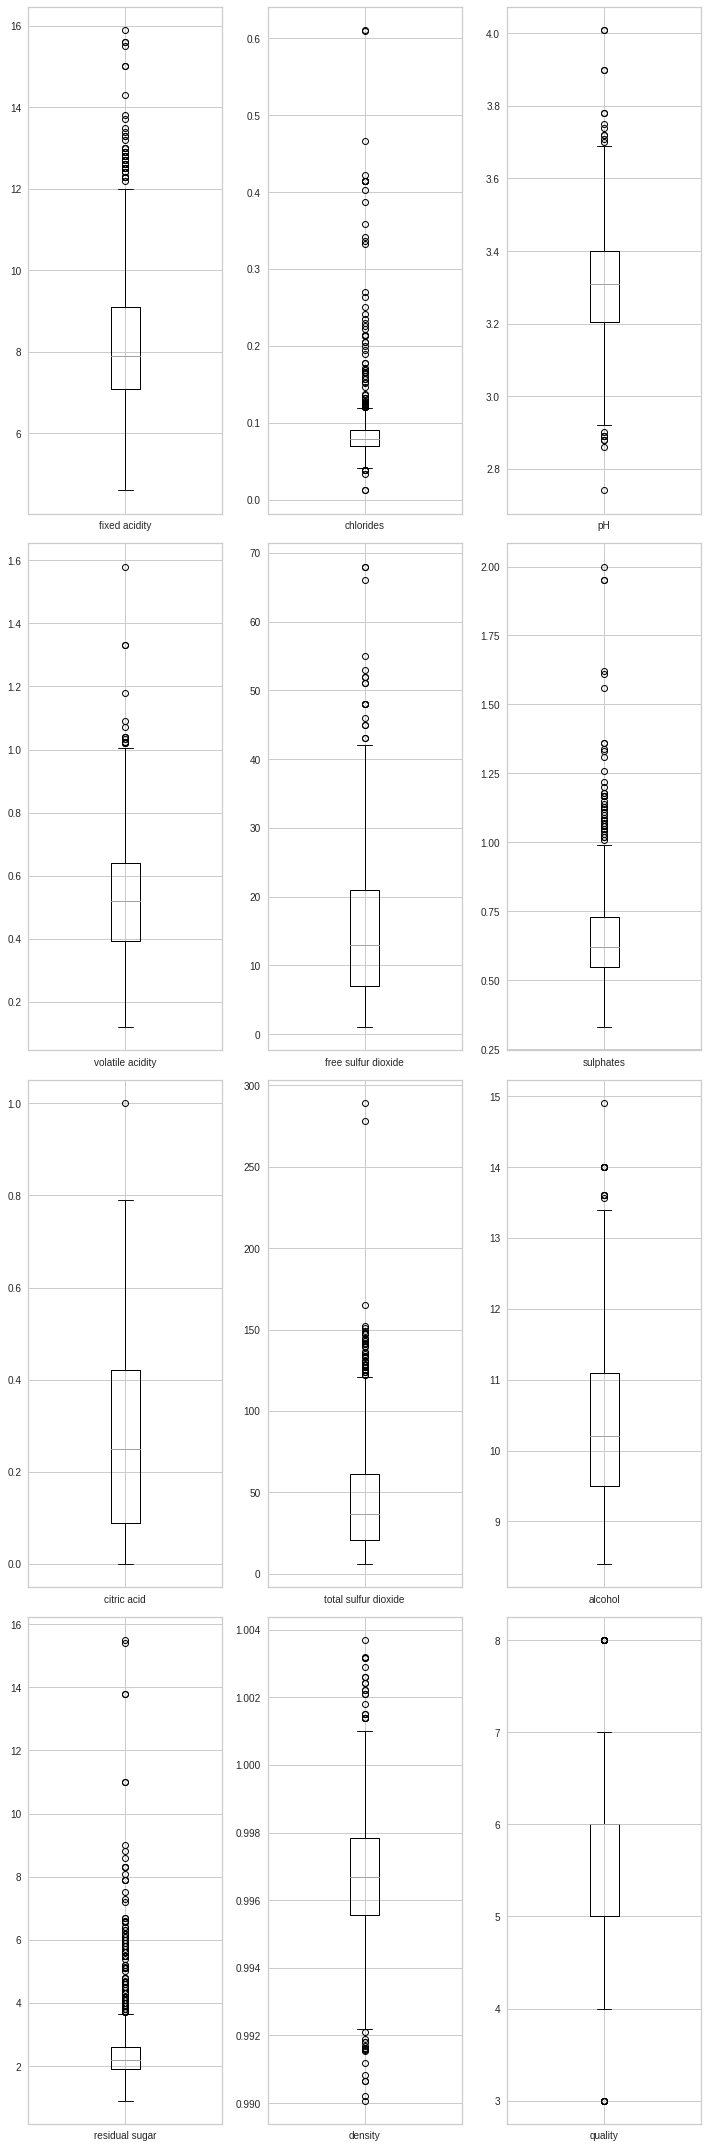

In [148]:
# Boxplots

fig, ax = plt.subplots(4, 3, figsize = (10, 30), tight_layout=True)
wine_data_copy.boxplot(column= ["fixed acidity"], ax=ax[0][0])
wine_data_copy.boxplot(column= ['volatile acidity'], ax=ax[1][0])
wine_data_copy.boxplot(column= ["citric acid"], ax=ax[2][0])
wine_data_copy.boxplot(column= ['residual sugar'], ax=ax[3][0])
wine_data_copy.boxplot(column= ['chlorides'], ax=ax[0][1])
wine_data_copy.boxplot(column= ['free sulfur dioxide'], ax=ax[1][1])
wine_data_copy.boxplot(column= ['total sulfur dioxide'], ax=ax[2][1])
wine_data_copy.boxplot(column= ['density'], ax=ax[3][1])
wine_data_copy.boxplot(column= ['pH'], ax=ax[0][2])
wine_data_copy.boxplot(column= ['sulphates'], ax=ax[1][2])
wine_data_copy.boxplot(column= ['alcohol'], ax=ax[2][2])
wine_data_copy.boxplot(column= ['quality'], ax=ax[3][2])

print("O comportamento das variaveis estao ok, pois ha uma variancia aceitavel para um boxplot.", end = '\n\n')

In [149]:
# Aferindo a relacao entre as variaveis. 

matriz_correlacao = wine_data_copy.corr()
print ("Essa matriz sera comparada com a influencia das variaveis para o treinamento com machine learning.", end = '\n\n')
print (matriz_correlacao)

Essa matriz sera comparada com a influencia das variaveis para o treinamento com machine learning.

                      fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000         -0.250728     0.673157   
volatile acidity          -0.250728          1.000000    -0.544187   
citric acid                0.673157         -0.544187     1.000000   
residual sugar             0.171831         -0.005751     0.175815   
chlorides                  0.107889          0.056336     0.245312   
free sulfur dioxide       -0.164831         -0.001962    -0.057589   
total sulfur dioxide      -0.110628          0.077748     0.036871   
density                    0.681501          0.016512     0.375243   
pH                        -0.685163          0.221492    -0.546339   
sulphates                  0.174592         -0.276079     0.331232   
alcohol                   -0.075055         -0.203909     0.106250   
quality                    0.121970         -0.407394     0.

In [150]:
# Definindo as variaveis de treinamento.

X, Y = wine_data_copy.drop(['quality', 'Id'], axis=1), wine_data_copy['quality']
X_treino, X_validacao, Y_treino, Y_validacao = sci.model_selection.train_test_split(X, Y, shuffle = False, test_size=0.3)#, random_state=1)

media = np.mean(X_treino.astype(float), axis = 0)
desv_pad = np.nanstd(X_treino.astype(float), axis = 0)

X_treino_nor = (X_treino - media) / desv_pad
X_validacao_nor = (X_treino - media) / desv_pad

In [151]:
# Primeiro metodo de treinamento, XGBoost.

modelo_xgb = XGBClassifier()
modelo_xgb.fit(X_treino, Y_treino)

Y_predito_xgb = modelo_xgb.predict(X_validacao)
predicoes_xgb = [round(value) for value in Y_predito_xgb]

acuracia_xgb = sci.metrics.accuracy_score(Y_validacao, predicoes_xgb)

print("Acuracia XGB: %.2f%%" % (acuracia_xgb * 100.0))

scores_xgb = cross_val_score(modelo_xgb, X_treino, Y_treino, cv=5)
media_score_xgb = np.mean(scores_xgb)
desv_pad_score_xgb = np.std(scores_xgb)
print('Acuracia XGB apos validacao cruzada: {}% +/- {}% '.format(media_score_xgb*100, desv_pad_score_xgb*100))

erro_absoluto_medio_xgb = mean_absolute_error(Y_predito_xgb, Y_validacao)
print('Erro absoluto XGB: {}'. format(erro_absoluto_medio_xgb))



# Calculando a importancia das variaveis para o metodo.
r = permutation_importance(modelo_xgb, X_treino, Y_treino, n_repeats=30, random_state=0)
importancia = np.abs(r.importances_mean) / np.sum(np.abs(r.importances_mean))
j = 0
print('\n')
for i in variaveis_idxs:
  print('Variavel: {} \n Importancia: {}%' .format(wine_data_copy.columns[i], importancia[j]*100))
  j = j + 1

Acuracia XGB: 58.02%


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


Acuracia XGB apos validacao cruzada: 52.75000000000001% +/- 3.4141250709369144% 
Erro absoluto XGB: 0.47230320699708456


Variavel: fixed acidity 
 Importancia: 5.947419869321396%
Variavel: volatile acidity 
 Importancia: 12.527653444461597%
Variavel: citric acid 
 Importancia: 7.4702886247877744%
Variavel: residual sugar 
 Importancia: 6.2766887894222325%
Variavel: chlorides 
 Importancia: 5.715902659875493%
Variavel: free sulfur dioxide 
 Importancia: 3.488192622318257%
Variavel: total sulfur dioxide 
 Importancia: 8.180274733755208%
Variavel: density 
 Importancia: 4.609764881411739%
Variavel: pH 
 Importancia: 5.04193033904409%
Variavel: sulphates 
 Importancia: 13.124453362144365%
Variavel: alcohol 
 Importancia: 27.61743067345785%


In [135]:
# Segundo metodo de treinamento, KNN (K Nearest Neighbor)

# Antes de comecarmos, precisamos entender o que esse metodo faz, ele trabalha com distancias, 
# se houver uma discrepancia muito grande na distancia, o correto eh trabalhar com as variaveis normalizadas.
model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(X_treino, Y_treino)

scores_knn = cross_val_score(model_knn, X_treino, Y_treino, cv=5)
media_score_knn = np.mean(scores_knn)
desv_pad_score_knn = np.std(scores_knn)
print('Acuracia KNN apos validacao cruzada: {}% +/- {}% '.format(media_score_knn*100, desv_pad_score_knn*100))

Y_predito_knn_validacao = model_knn.predict(X_validacao)
erro_absoluto_medio_knn = mean_absolute_error(Y_predito_knn_validacao, Y_validacao)
print('Erro absoluto KNN: {}'. format(erro_absoluto_medio_knn))


# Calculando a importancia das variaveis para o metodo.
r = permutation_importance(model_knn, X_treino, Y_treino, n_repeats=30, random_state=0)
importancia = np.abs(r.importances_mean) / np.sum(np.abs(r.importances_mean))
j = 0
print('\n')
for i in variaveis_idxs:
  print('Variavel: {} \n Importancia: {}%' .format(wine_data_copy.columns[i], importancia[j]*100))
  j = j + 1

Acuracia KNN apos validacao cruzada: 46.12500000000001% +/- 7.0644355754723955% 
Erro absoluto KNN: 0.6297376093294461


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,




Variavel: fixed acidity 
 Importancia: 9.955191895577638%
Variavel: volatile acidity 
 Importancia: 0.6818624586012179%
Variavel: citric acid 
 Importancia: 0.46756282875512434%
Variavel: residual sugar 
 Importancia: 2.1527371907266777%
Variavel: chlorides 
 Importancia: 0.009740892265732189%
Variavel: free sulfur dioxide 
 Importancia: 29.475939996103634%
Variavel: total sulfur dioxide 
 Importancia: 47.40892265731539%
Variavel: density 
 Importancia: 0.0%
Variavel: pH 
 Importancia: 0.37015390609778864%
Variavel: sulphates 
 Importancia: 0.18507695304890903%
Variavel: alcohol 
 Importancia: 9.292811221507892%


In [136]:
# Terceiro metodo de treinamento, Decision Tree

model_decision_tree = DecisionTreeClassifier(random_state=1)
model_decision_tree.fit(X_treino, Y_treino)

Y_predito_decision_tree = model_decision_tree.predict(X_validacao)


scores_decision_tree = cross_val_score(model_decision_tree, X_treino, Y_treino, cv=5)
media_score_decision_tree = np.mean(scores_decision_tree)
desv_pad_score_decision_tree = np.std(scores_decision_tree)
print('Acuracia Decision Tree apos validacao cruzada: {}% +/- {}% '.format(media_score_decision_tree*100, desv_pad_score_decision_tree*100))

erro_absoluto_medio_decision_tree = mean_absolute_error(Y_predito_decision_tree, Y_validacao)
print('Erro absoluto Decision Tree: {}'. format(erro_absoluto_medio_decision_tree))


# Calculando a importancia das variaveis para o metodo.
r = permutation_importance(model_decision_tree, X_treino, Y_treino, n_repeats=30, random_state=0)
importancia = np.abs(r.importances_mean) / np.sum(np.abs(r.importances_mean))
j = 0
print('\n')
for i in variaveis_idxs:
  print('Variavel: {} \n Importancia: {}%' .format(wine_data_copy.columns[i], importancia[j]*100))
  j = j + 1

Acuracia Decision Tree apos validacao cruzada: 47.87499999999999% +/- 4.0039043445117395% 
Erro absoluto Decision Tree: 0.6180758017492711


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,




Variavel: fixed acidity 
 Importancia: 7.0146745827265615%
Variavel: volatile acidity 
 Importancia: 8.240170269967514%
Variavel: citric acid 
 Importancia: 6.096112915873195%
Variavel: residual sugar 
 Importancia: 6.1834882939397335%
Variavel: chlorides 
 Importancia: 5.076733505096896%
Variavel: free sulfur dioxide 
 Importancia: 7.090847989246107%
Variavel: total sulfur dioxide 
 Importancia: 7.359695306373923%
Variavel: density 
 Importancia: 5.45087935476644%
Variavel: pH 
 Importancia: 9.11392405063291%
Variavel: sulphates 
 Importancia: 15.236921698218891%
Variavel: alcohol 
 Importancia: 23.136552033157834%


In [137]:
# Criando um dataset com Oversampling

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_treino, Y_treino)

In [138]:
# Quarto metodo de treinamento, XGBoost com Oversampling.

modelo_xgb_over = XGBClassifier()
modelo_xgb_over.fit(X_resampled, y_resampled)

Y_predito_xgb_over = modelo_xgb.predict(X_validacao)
predicoes_xgb_over = [round(value) for value in Y_predito_xgb_over]

acuracia_xgb_over = sci.metrics.accuracy_score(Y_validacao, predicoes_xgb_over)

print("Acuracia XGB: %.2f%%" % (acuracia_xgb_over * 100.0))

scores_xgb_over = cross_val_score(modelo_xgb, X_resampled, y_resampled, cv=5)
media_score_xgb_over = np.mean(scores_xgb_over)
desv_pad_score_xgb_over = np.std(scores_xgb_over)
print('Acuracia XGB apos validacao cruzada: {}% +/- {}% '.format(media_score_xgb_over*100, desv_pad_score_xgb_over*100))

erro_absoluto_medio_xgb_over = mean_absolute_error(Y_predito_xgb_over, Y_validacao)
print('Erro absoluto XGB: {}'. format(erro_absoluto_medio_xgb_over))

# Calculando a importancia das variaveis para o metodo.
r = permutation_importance(modelo_xgb_over, X_resampled, y_resampled, n_repeats=30, random_state=0)
importancia = np.abs(r.importances_mean) / np.sum(np.abs(r.importances_mean))
j = 0
print('\n')
for i in variaveis_idxs:
  print('Variavel: {} \n Importancia: {}%' .format(wine_data_copy.columns[i], importancia[j]*100))
  j = j + 1

Acuracia XGB: 58.02%
Acuracia XGB apos validacao cruzada: 83.28502415458937% +/- 1.7444898633108976% 
Erro absoluto XGB: 0.47230320699708456


Variavel: fixed acidity 
 Importancia: 4.206709299417668%
Variavel: volatile acidity 
 Importancia: 13.420385123789789%
Variavel: citric acid 
 Importancia: 7.398806759315496%
Variavel: residual sugar 
 Importancia: 2.6812189632381815%
Variavel: chlorides 
 Importancia: 3.3314279589868163%
Variavel: free sulfur dioxide 
 Importancia: 3.781572648351254%
Variavel: total sulfur dioxide 
 Importancia: 3.243899824943731%
Variavel: density 
 Importancia: 2.4632917723553995%
Variavel: pH 
 Importancia: 4.253152799113999%
Variavel: sulphates 
 Importancia: 10.02643706905791%
Variavel: alcohol 
 Importancia: 45.193097781429756%


In [139]:
# Quinto metodo de treinamento, KNN (K Nearest Neighbor) com Oversampling

# Antes de comecarmos, precisamos entender o que esse metodo faz, ele trabalha com distancias, 
# se houver uma discrepancia muito grande na distancia, o correto eh trabalhar com as variaveis normalizadas.
model_knn_over = KNeighborsClassifier(n_neighbors=10)
model_knn_over.fit(X_resampled, y_resampled)

scores_knn_over = cross_val_score(model_knn_over, X_resampled, y_resampled, cv=5)
media_score_knn_over = np.mean(scores_knn_over)
desv_pad_score_knn_over = np.std(scores_knn_over)
print('Acuracia KNN apos validacao cruzada: {}% +/- {}% '.format(media_score_knn_over*100, desv_pad_score_knn_over*100))

Y_predito_knn_validacao_over = model_knn_over.predict(X_validacao)
erro_absoluto_medio_knn_over = mean_absolute_error(Y_predito_knn_validacao_over, Y_validacao)
print('Erro absoluto KNN: {}'. format(erro_absoluto_medio_knn_over))


# Calculando a importancia das variaveis para o metodo.
r = permutation_importance(model_knn_over, X_resampled, y_resampled, n_repeats=30, random_state=0)
importancia = np.abs(r.importances_mean) / np.sum(np.abs(r.importances_mean))
j = 0
print('\n')
for i in variaveis_idxs:
  print('Variavel: {} \n Importancia: {}%' .format(wine_data_copy.columns[i], importancia[j]*100))
  j = j + 1

Acuracia KNN apos validacao cruzada: 72.22222222222223% +/- 1.3230013466308346% 
Erro absoluto KNN: 0.9883381924198251


Variavel: fixed acidity 
 Importancia: 12.979270428378022%
Variavel: volatile acidity 
 Importancia: 0.00869424813384001%
Variavel: citric acid 
 Importancia: 0.0993628358153332%
Variavel: residual sugar 
 Importancia: 3.0765218039322835%
Variavel: chlorides 
 Importancia: 0.0012420354476915115%
Variavel: free sulfur dioxide 
 Importancia: 29.187833020754418%
Variavel: total sulfur dioxide 
 Importancia: 41.40076757790668%
Variavel: density 
 Importancia: 0.0%
Variavel: pH 
 Importancia: 0.07824823320457437%
Variavel: sulphates 
 Importancia: 0.012420354476918825%
Variavel: alcohol 
 Importancia: 13.155639461950244%


In [140]:
# Sexto metodo de treinamento, Decision Tree com Oversampling

model_decision_tree_over = DecisionTreeClassifier(random_state=1)
model_decision_tree_over.fit(X_resampled, y_resampled)

Y_predito_decision_tree_over = model_decision_tree_over.predict(X_validacao)


scores_decision_tree_over = cross_val_score(model_decision_tree, X_resampled, y_resampled, cv=5)
media_score_decision_tree_over = np.mean(scores_decision_tree_over)
desv_pad_score_decision_tree_over = np.std(scores_decision_tree_over)
print('Acuracia Decision Tree apos validacao cruzada: {}% +/- {}% '.format(media_score_decision_tree_over*100, desv_pad_score_decision_tree_over*100))

erro_absoluto_medio_decision_tree_over = mean_absolute_error(Y_predito_decision_tree_over, Y_validacao)
print('Erro absoluto Decision Tree: {}'. format(erro_absoluto_medio_decision_tree_over))


# Calculando a importancia das variaveis para o metodo.
r = permutation_importance(model_decision_tree, X_resampled, y_resampled, n_repeats=30, random_state=0)
importancia = np.abs(r.importances_mean) / np.sum(np.abs(r.importances_mean))
j = 0
print('\n')
for i in variaveis_idxs:
  print('Variavel: {} \n Importancia: {}%' .format(wine_data_copy.columns[i], importancia[j]*100))
  j = j + 1

Acuracia Decision Tree apos validacao cruzada: 83.5265700483092% +/- 2.283343439245695% 
Erro absoluto Decision Tree: 0.6151603498542274


Variavel: fixed acidity 
 Importancia: 6.577477030047181%
Variavel: volatile acidity 
 Importancia: 11.57871864911845%
Variavel: citric acid 
 Importancia: 5.11671219269928%
Variavel: residual sugar 
 Importancia: 5.590389868388378%
Variavel: chlorides 
 Importancia: 4.783958281599205%
Variavel: free sulfur dioxide 
 Importancia: 6.913955798361063%
Variavel: total sulfur dioxide 
 Importancia: 7.465855475540102%
Variavel: density 
 Importancia: 5.192450956046685%
Variavel: pH 
 Importancia: 6.881052892972438%
Variavel: sulphates 
 Importancia: 15.828159920536377%
Variavel: alcohol 
 Importancia: 24.071268934690842%


In [141]:
# ROC Curve XGB
#model = XGBClassifier()
#visualizer = ROCAUC(model)

#visualizer.fit(X_treino, Y_treino)        # Fit the training data to the visualizer
#visualizer.score(X_validacao, Y_validacao.values.reshape(-1,1))        # Evaluate the model on the test data
#visualizer.show()                       # Finalize and render the figure\


print('Nao estou conseguindo aplicar a ROC Curve no metodo XG Boost')

Nao estou conseguindo aplicar a ROC Curve no metodo XG Boost


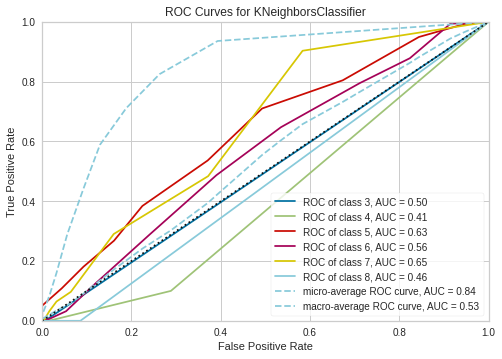

In [142]:
# ROC Curve KNN
model = KNeighborsClassifier(n_neighbors=10)
visualizer = ROCAUC(model)

visualizer.fit(X_treino, Y_treino)        # Fit the training data to the visualizer
visualizer.score(X_validacao, Y_validacao.values.reshape(-1,1))        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure\


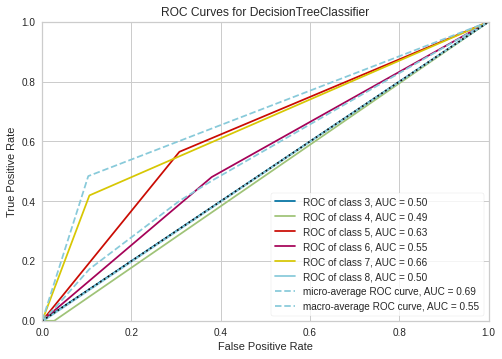

In [143]:
# ROC Curve Decision Tree
model = DecisionTreeClassifier(random_state=1)
visualizer = ROCAUC(model)

visualizer.fit(X_treino, Y_treino)        # Fit the training data to the visualizer
visualizer.score(X_validacao, Y_validacao.values.reshape(-1,1))        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure\
